#### Week 11
#### DSC-550 Data Mining
#### Swapnil Chavan
#### 05/26/2024

In this exercise, you will build a convolutional neural network (CNN) to classify handwritten digits from the MNIST dataset. The steps to build a CNN classifier are outlined in section 20.15 of the Machine Learning with Python Cookbook, but keep in mind that your code may need to be modified depending on your version of Keras.

***1. Load the MNIST data set.***

In [1]:
import torch

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [3]:
from torchvision import datasets
from torchvision.transforms import ToTensor
train_data = datasets.MNIST(
    root = 'data',
    train = True,                         
    transform = ToTensor(), 
    download = True,            
)
test_data = datasets.MNIST(
    root = 'data', 
    train = False, 
    transform = ToTensor()
)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|███████████████████████████████████████████████████████████████████| 9912422/9912422 [00:01<00:00, 9840160.48it/s]


Extracting data\MNIST\raw\train-images-idx3-ubyte.gz to data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|████████████████████████████████████████████████████████████████████████| 28881/28881 [00:00<00:00, 453118.13it/s]


Extracting data\MNIST\raw\train-labels-idx1-ubyte.gz to data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|███████████████████████████████████████████████████████████████████| 1648877/1648877 [00:00<00:00, 1859230.54it/s]


Extracting data\MNIST\raw\t10k-images-idx3-ubyte.gz to data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|█████████████████████████████████████████████████████████████████████████| 4542/4542 [00:00<00:00, 4551010.22it/s]


Extracting data\MNIST\raw\t10k-labels-idx1-ubyte.gz to data\MNIST\raw



In [4]:
print(train_data)

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()


In [5]:
print(test_data)

Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()


***2. Display the first five images in the training data set (see section 8.1 in the Machine Learning with Python Cookbook). Compare these to the first five training labels.***

In [6]:
import matplotlib.pyplot as plt

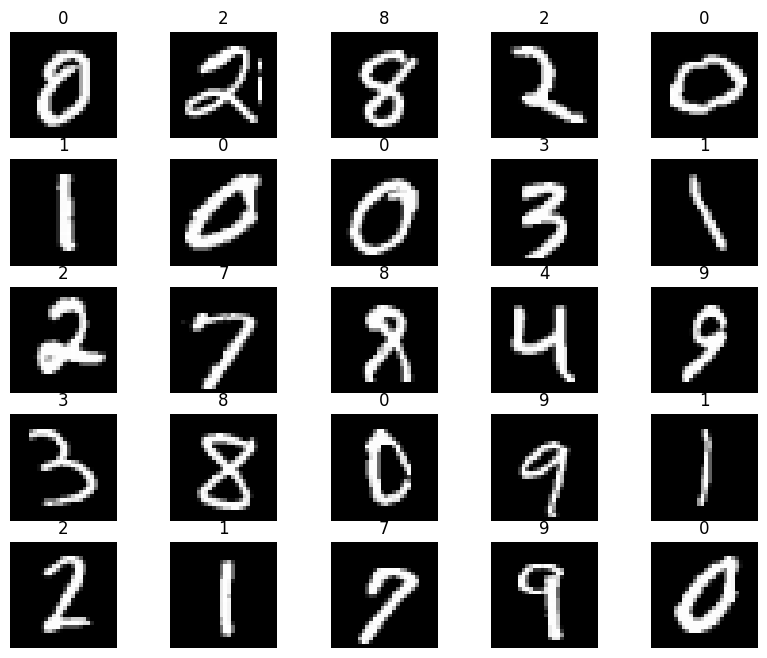

In [7]:
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

***3. Build and train a Keras CNN classifier on the MNIST training set.***

The Dataset retrieves our dataset’s features and labels one sample at a time. While training a model, we typically want to pass samples in “minibatches”, reshuffle the data at every epoch to reduce model overfitting, and use Python’s multiprocessing to speed up data retrieval.

DataLoader is an iterable that abstracts this complexity for us in an easy API.

Let's load the data 

In [8]:
from torch.utils.data import DataLoader
loaders = {
    'train' : torch.utils.data.DataLoader(train_data, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=1),
    
    'test'  : torch.utils.data.DataLoader(test_data, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=1),
}
loaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x265c0ca95b0>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x265c0c19c10>}

Let us create convolution neural network using torch.nn.Module. torch.nn.Module will be base class for all neural network modules. We will use 2 fully convolutional layers, Relu activation function and MaxPooling.

In [9]:
import torch.nn as nn
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, 5, 1, 2),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        # fully connected layer, output 10 classes
        self.out = nn.Linear(32 * 7 * 7, 10)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output, x    # return x for visualization

In [10]:
cnn = CNN()
print(cnn)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)


***Loss Function***

In [11]:
loss_func = nn.CrossEntropyLoss()   
loss_func

CrossEntropyLoss()

*** Optimization Function ***

In [12]:
from torch import optim
optimizer = optim.Adam(cnn.parameters(), lr = 0.01)   
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    weight_decay: 0
)

***Train The Model***

In [20]:
from torch.autograd import Variable
num_epochs = 10
def train(num_epochs, cnn, loaders):
    
    cnn.train()
        
    # Train the model
    total_step = len(loaders['train'])
        
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(loaders['train']):
            
            # gives batch data, normalize x when iterate train_loader
            b_x = Variable(images)   # batch x
            b_y = Variable(labels)   # batch y
            output = cnn(b_x)[0]               
            loss = loss_func(output, b_y)
            
            # clear gradients for this training step   
            optimizer.zero_grad()           
            
            # backpropagation, compute gradients 
            loss.backward()    
            # apply gradients             
            optimizer.step()                
            
            if (i+1) % 100 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))
                pass
        
            pass
    
        pass
train(num_epochs, cnn, loaders)

Epoch [1/10], Step [100/600], Loss: 0.0627
Epoch [1/10], Step [200/600], Loss: 0.0529
Epoch [1/10], Step [300/600], Loss: 0.0887
Epoch [1/10], Step [400/600], Loss: 0.0157
Epoch [1/10], Step [500/600], Loss: 0.0298
Epoch [1/10], Step [600/600], Loss: 0.1287
Epoch [2/10], Step [100/600], Loss: 0.1521
Epoch [2/10], Step [200/600], Loss: 0.0592
Epoch [2/10], Step [300/600], Loss: 0.0908
Epoch [2/10], Step [400/600], Loss: 0.0347
Epoch [2/10], Step [500/600], Loss: 0.0826
Epoch [2/10], Step [600/600], Loss: 0.0168
Epoch [3/10], Step [100/600], Loss: 0.0117
Epoch [3/10], Step [200/600], Loss: 0.0734
Epoch [3/10], Step [300/600], Loss: 0.0091
Epoch [3/10], Step [400/600], Loss: 0.0087
Epoch [3/10], Step [500/600], Loss: 0.0264
Epoch [3/10], Step [600/600], Loss: 0.0101
Epoch [4/10], Step [100/600], Loss: 0.0390
Epoch [4/10], Step [200/600], Loss: 0.1538
Epoch [4/10], Step [300/600], Loss: 0.0179
Epoch [4/10], Step [400/600], Loss: 0.0419
Epoch [4/10], Step [500/600], Loss: 0.0150
Epoch [4/10

***4. Report the test accuracy of your model***
***5. Display a confusion matrix on the test set classifications.***

Accuracy of the model on the 10000 test images: 0.99


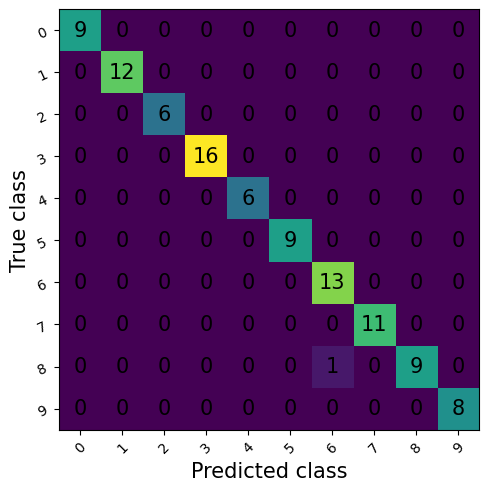

In [36]:
from torch import tensor
def test():
    # Test the model
    cnn.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in loaders['test']:
            test_output, last_layer = cnn(images)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            accuracy = (pred_y == labels).sum().item() / float(labels.size(0))
            pass
        
        metric = MulticlassConfusionMatrix(num_classes=10)
        metric.update(pred_y, labels)
        fig_, ax_ = metric.plot()
        
        print('Accuracy of the model on the 10000 test images: %.2f' % accuracy)

   
    pass
    

test()

***6. Summarize your results***

Perfromed step 4 and 5 together, the accuracy at the last iteration is 99%. And the confusion matrix is displaying the same thing. Confusion Matrix is also dispalying the result at the last iteration with 100 images.

Out of the 100 images in the last iteration, 1 time the model failed to predict the number. Actual number is 8 where as the model predicted it as 6. 